In [1]:
import numpy as np
import ciropt as co

np.random.seed(1)

# Discretize the dynamics of DI using `ciropt`.

### 1. Define a problem.

In [2]:
problem = co.CircuitOpt()

### 2. Define function classes for each $f_i$. 
In this example there is only single function with smoothness $M=\infty$ and strong convexity $\mu=4$.

In [3]:
mu = 0.5
M = np.inf
f = co.def_function(problem, mu, M)

### 3. Define optimal points.

In [4]:
x_star, y_star, f_star = f.stationary_point(return_gradient_and_function_value=True)

### 4. Define discretization parameters, for simplicity take $\alpha=0$ and $\beta=1$.

In [5]:
h, b, d = problem.h, problem.b, problem.d

### 5. Define values for RLC and one step transition for discretized V-I relations of given DI.

In [6]:
R, C = 1, 10


z_1 = problem.set_initial_point()
e2_1 = problem.set_initial_point()
x_1 = co.proximal_step(z_1, f, R/2)[0]
y_1 = (2 / R) * (z_1 - x_1)


e2_2 = e2_1  -  h / (2 * R * C) *  (R * y_1 + 3 * e2_1)  
z_2 = z_1  -  h / (4 * R * C) *  (5 * R * y_1 + 3 * e2_1)
x_2 = co.proximal_step(z_2, f, R/2)[0]
y_2 = (2 / R) * (z_2 - x_2)

v_C1_1 = e2_1 / 2 - z_1
v_C1_2 = e2_2 / 2 - z_2
v_C2_1 = e2_1; v_C2_2 = e2_2 
e1_1 = (e2_1 - R * y_1) / 2

### 6. Define dissipative term and set the objective to maximize descent coefficients.
Solve the final problem.

In [7]:
E_1 = (C/2) * (v_C1_1 + x_star)**2 + (C/2) * (v_C2_1)**2
E_2 = (C/2) * (v_C1_2 + x_star)**2 + (C/2) * (v_C2_2)**2
Delta_1 = b * (x_1 - x_star) * (y_1 - y_star) \
        + d * (1/R) * ((e1_1)**2 + (e1_1 - e2_1)**2 + (e2_1)**2)


problem.set_performance_metric(E_2 - (E_1 - Delta_1))

In [8]:
problem.obj = problem.b + problem.d * 1.01

params, sol = problem.solve(solver="ipopt", verbose=False)[:2]

dim_G=5, dim_F=3
Ipopt total # of variables = 42
Actual # of variables = 31


## Resulting parameters.

In [9]:
params

{'b': 6.633663115052066, 'h': 6.633663116640959, 'd': 0.03284015545637719}

# Solve your problem using new algorithm. 

We consider the primal problem
$$
\begin{array}{ll}
\text{minimize} & f(x) = \sum_i
\begin{cases}
(x_i - c_i)^2 & |x_i-c_i| \leq 1 \\
2(x_i-c_i)-1 & |x_i-c_i| > 1
\end{cases} \\
\text{subject to} & Ax = b
\end{array}
$$
and solve the dual problem
$$
\begin{array}{ll}
\text{minimize} & g(y) = f^*(-A^T y ) + b^Ty
\end{array}
$$

The proximal operator $\mathbf{prox}_{\alpha g}(\tilde y)$ is equivalent to
$$
x = \arg\min \left( f(x) + (\alpha/2)\|Ax-b\|_2^2 + \tilde y^T(Ax-b) \right),
\qquad y = \tilde y + \alpha(Ax-b)
$$

Note that for $f$ is huber loss, thus $f$ is $2$-smooth and $f^*$ is $1/2$-strongly convex. 
Then for wide matrix $A$ with full column space, $g$ is $\lambda_{\min}(AA^T)/2$-strongly convex, as shown below
for $u_i \in \partial g(y_i)$.
$$
\langle u_1 - u_1, y_1 - y_2 \rangle 
= \langle \partial f^*(-A^T y_1) - \partial f^*(-A^T y_2), -A^T(y_1 - y_2) \rangle \geq \mu \|A^T(y_1 - y_2)\|^2  \geq \lambda_{\min}(AA^T) \mu \|y_1 - y_2\|^2
$$

In [10]:
import cvxpy as cp
import matplotlib.pyplot as plt
from scipy.special import huber as sp_huber

In [11]:
n = 100
m = 100
A = np.random.randn(m, n)
rank = 30
A[rank:] = 0
b = np.random.randn(m)
b[rank:] = 0
c = np.random.randn(n) 

In [12]:
lambda_min = np.linalg.eigvals(A[:rank] @ A[:rank].T).min()
A /= np.sqrt(lambda_min)
assert np.allclose(np.linalg.eigvals(A[:rank] @ A[:rank].T).min(), 1)

In [13]:
def prox_oracle_g(n, R, A, b, c, tilde_y, coeff=1):
    x = cp.Variable(n) 
    f = coeff * cp.sum(cp.huber(x - c, M=1)) + tilde_y.T @ (A @ x - b) + (R/2) * cp.sum_squares(A @ x - b) 
    objective = cp.Minimize(f)
    prob = cp.Problem(objective, [])
    prob.solve()
    y = tilde_y + R * (A @ x.value - b)
    return y, x.value


def dual_obj_cvx(n, A, b, c, y, coeff=1):
    x = cp.Variable(n) 
    f = -coeff * cp.sum(cp.huber(x - c, M=1)) - x.T @ (A.T @ y)
    prob = cp.Problem(cp.Maximize(f), [])
    prob.solve(solver=cp.MOSEK) 
    return -(f.value + b @ y)


def solve_primal_cvx(n, A, b, c, coeff=1):
    x = cp.Variable(n) 
    f = coeff * cp.sum(cp.huber(x - c, M=1))
    objective = cp.Minimize(f)
    constraints = [A @ x == b]
    prob = cp.Problem(objective, constraints)
    prob.solve()
    return f.value, x.value, constraints[0].dual_value

In [14]:
f_star, x_star, y_star = solve_primal_cvx(n, A, b, c)
print(f"{f_star=}, {np.linalg.matrix_rank(A)=}")
assert np.allclose(dual_obj_cvx(n, A, b, c, y_star), f_star)

f_star=33.97228558563741, np.linalg.matrix_rank(A)=30


In [15]:
losses = []
z_0 = np.random.randn(m)
e2_0 = np.zeros(n)
for k in range(50):
    x1, primal = prox_oracle_g(n, R/2, A, b, c, z_0)
    g_x1 = (2 / R) * (z_0 - x1)
    e2_1 = e2_0 - params["h"] / (2 * R * C) * (R * g_x1 + 3 * e2_0)
    z_1 = z_0 - params["h"] / (4 * R * C) * (5 * R * g_x1 + 3 * e2_0)
    losses += [np.abs(dual_obj_cvx(n, A, b, c, x1) - f_star) / f_star]
    e2_0 = e2_1
    z_0 = z_1
    if k % 10 == 0:
        print(losses[-1] , sp_huber(1, primal-c).sum())

print(f"{losses[-1]=}")

0.33450638047780357 10.18000662133907
1.5052856505963097e-05 15.031666083681783
1.6904386980026964e-08 15.241121606712515
9.646166105206126e-13 15.406829739910162
2.685344562908759e-11 15.556424276769329
losses[-1]=2.688272713938093e-11


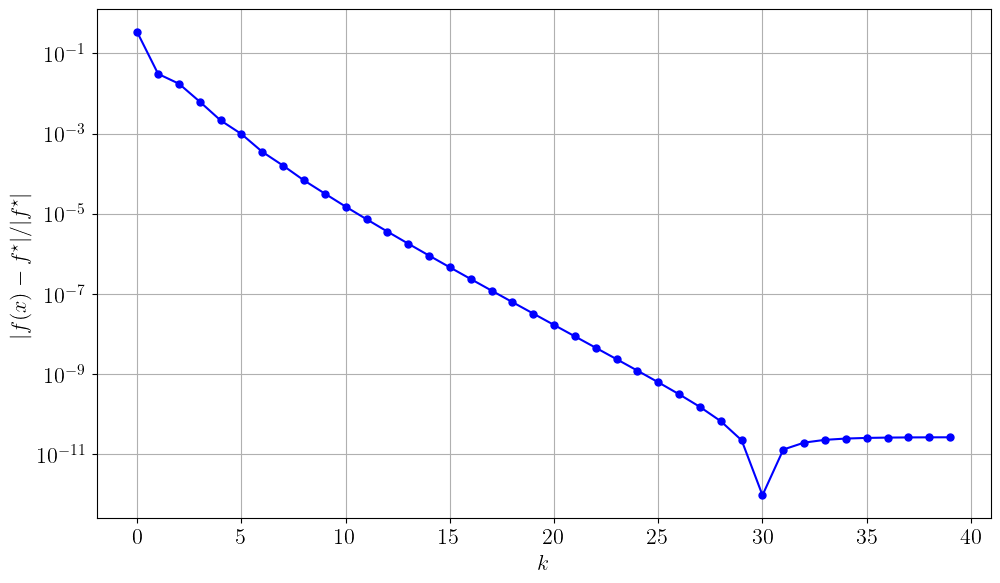

In [17]:
plt.figure(figsize=(10, 6))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.plot(losses[:40], label=r'$f(x^k)$', color='blue', marker='o', ms=5)

plt.xlabel(r'$k$', fontsize=16)
plt.ylabel(r"$|f(x) - f^\star|/|f^\star|$", fontsize=16)
# plt.legend(fontsize=16) 
plt.xticks(fontsize=16, fontname='serif')
plt.yticks(fontsize=16, fontname='serif')
# plt.legend(fontsize=16) 
plt.grid(True)
plt.tight_layout()
plt.yscale('log')
plt.savefig(f'figures/simple_hello_wrld.pdf')
plt.show()

In [19]:
params["h"] / (2*C*R), params["h"] / (4*C*R)

(0.331683155832048, 0.165841577916024)